In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset
import cv2
import json
from torch.utils.data import DataLoader


In [2]:
train_coco_json_path = '/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/annotations/person_keypoints_train2017.json'
train_coco_img_path  = '/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/images/train2017/'
test_coco_json_path = '/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/annotations/person_keypoints_val2017.json'
test_coco_img_path = '/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/images/val2017'

In [90]:
# returns the cropped COCO images
class CustomCOCO(Dataset):

    def __init__(self, json_path, img_path):
        data = json.load(open(json_path))
        self.json_path = json_path
        self.anot = data['annotations']

        #separate image_ids, keypoints, and bbox from data
        self.img_path  = img_path
        self.target_height = 256
        self.target_width = 192

    def __len__(self):
        return len(self.anot)

    def __getitem__(self, idx):
        self.load_img(idx)
        img = self.resized_image
        hp = np.array(self.create_heatmap())
        # tenrsor size
        return torch.Tensor(img).permute(2,0,1), torch.Tensor(hp), torch.Tensor(self.keypoint_confidence)
    
    def get_id(self, index):
        self._target_image_info(index)
        return self.target_id
    
    def _target_image_info(self, index):
        target_data = self.anot[index]
        self.target_kp = target_data['keypoints']
        self.target_bbox = target_data['bbox']
        self.target_id = target_data['image_id']

    def _crop_img(self):
        X,Y,width,height = self.target_bbox
        X,Y,width,height = int(X),int(Y), int(width)+1, int(height)+1

        self.padding_up, padding_down, self.padding_left, padding_right = 0,0,0,0

        if height/width < 4/3:
            original_height = height
            height = int(3*width/4)
            height_change = height - original_height
            ## 5% padding for robustness
            original_width = width
            width = int(width * 1.05)
            width_change = width - original_width

        else:
            original_width = width
            width = int(3*height/4)
            width_change = width - original_width
            ## 5% padding for robustness
            original_height = height
            height = int(height * 1.05)
            height_change = height - original_height

        Y_start = Y-int(height_change/2)
        Y_end   = Y+height-int(height_change/2)
        X_start = X-int(width_change/2)
        X_end   = X-int(width_change/2)+width

        #print("X and Y", Y_start, Y_end, X_start, X_end)

        
        if Y_start<0 or X_start <0:
            # apply padding -> up and left
            img_size = self.target_image.shape
            #print("img_size ", img_size)
            pad = min(Y-int(height_change/2), X-int(width_change/2)) # pick more negative one
            pad = abs(pad)+20
            Y_start += pad; X_start += pad; Y_end += pad; X_end += pad
            self.padding_up += pad; self.padding_left += pad
            #print("pad: ", pad)
            zero_array = np.zeros((img_size[0] + pad, img_size[1]+ pad, 3))
            zero_array[pad:img_size[0]+pad, pad:img_size[1]+pad, :] = self.target_image/255.0
            self.target_image = zero_array

        img_size = self.target_image.shape
        if Y_end > img_size[0] or X_end > img_size[1]:
            # apply padding -> down and right
            pad = max(Y_end-img_size[0], X_end-img_size[1])
            pad = abs(pad)+20
            Y_end += pad; X_end += pad
            zero_array = np.zeros((img_size[0] + pad, img_size[1]+ pad, 3))
            zero_array[:img_size[0], :img_size[1], :] = self.target_image/255.0
            self.target_image = zero_array

        #print("right before cropping X and Y", Y_start, Y_end, X_start, X_end)
        self.cropped_image = self.target_image[Y_start:Y_end, X_start:X_end, :]
        #print("after cropping ", self.cropped_image.shape)

        # if Y-int(height_change/2) < 0:
        #     self.cropped_image = self.target_image[1:Y+height-int(height_change/2),X-int(width_change/2):X-int(width_change/2)+width]
        
        self.width = width; self.height = height
        self.width_trans = X - int(width_change/2)
        self.height_trans = Y - int(height_change/2)

    def _resize_img(self):
        dim = (self.target_width, self.target_height)
        #print("img size before resizing: ", self.cropped_image.shape)
        self.resized_image = cv2.resize(self.cropped_image, dim, interpolation=cv2.INTER_AREA)
        #print(torch.Tensor(self.resized_image).shape)

    def load_img(self, index):
        self._target_image_info(index)
        full_target_id = str(self.target_id).rjust(12, '0')
        target_img_path = self.img_path + full_target_id + '.jpg'
        #print("id: ", full_target_id)
        self.target_image = cv2.imread(target_img_path)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)

        # apply transformation
        #print("before crop: ", self.target_image.shape)
        self._crop_img()
        #print("before resize: ", self.cropped_image.shape)
        self._resize_img()

    # Only for Debugging
    def show_original(self):
        plt.imshow(self.target_image)
        plt.show()

    def show_original_bbox(self):
        X,Y,width,height = self.target_bbox
        X,Y,width,height = int(X),int(Y), int(width)+1, int(height)+1
        plt.imshow(self.target_image)
        ax = plt.gca()
        rect = patches.Rectangle((X,Y), width, height, linewidth=2, edgecolor='cyan', fill = False)
        ax.add_patch(rect)
        plt.show()

    def show_img(self):
        plt.imshow(self.resized_image)
        plt.show()

    def _create_kp_list(self):
        # execute after load_img() 
        self.keypoint = []
        self.keypoint_confidence = []
        for i, k in enumerate(self.target_kp):
            if i%3 != 0:
                continue

            x = self.target_kp[i] #k
            y = self.target_kp[i+1]
            confidence = self.target_kp[i+2]
            
            if confidence != 0:
                x = (x-self.width_trans+self.padding_left)*self.target_width/self.width
                y = (y-self.height_trans+self.padding_up)*self.target_height/self.height

            if x<0 or y<0:
                coordinate = (0,0)
                confidence = 0
            else:
                coordinate = (y,x)
            
            #print("coordinate: ", coordinate)
            self.keypoint.append(coordinate)
            self.keypoint_confidence.append(confidence)

    def create_heatmap(self):

        def gaussian_heatmap(image_size, center_point):
            ro = 0
            center_x = center_point[0]
            center_y = center_point[1]

            grid_y, grid_x = np.meshgrid(np.arange(image_size[0]), np.arange(image_size[1]))
            x = grid_x - center_x
            y = grid_y - center_y

            return np.exp(-1 * (x ** 2 - 2 * ro * x * y + y**2) / (2 * (1 - ro**2)))
        
        heatmap_list = []
        self._create_kp_list()
        for i, kp in enumerate(self.keypoint):
            heatmap_i = gaussian_heatmap((192, 256), kp)
            heatmap_list.append(heatmap_i)

        return heatmap_list

    def show_heatmap(self, heatmap_list):
        h = np.stack(heatmap_list)
        plt.imshow(h.max(axis=0)) 


In [83]:
mycoco = CustomCOCO(train_coco_json_path, train_coco_img_path)

In [ ]:
mycoco.load_img(1124)
mycoco.show_original_bbox()
#mycoco.show_crop()

In [43]:
id_to_path = dict()

mycoco = CustomCOCO(train_coco_json_path, train_coco_img_path)
for i in range(len(mycoco)):
    id_ = mycoco.get_id(i)
    id_to_path[id_] = i

95999 262464 <class 'int'>


id:  000000185302
before crop:  (424, 640, 3)
X and Y -5 20 575 610
right before cropping X and Y 20 45 600 635
before resize:  (25, 35, 3)
torch.Size([17, 256, 192])
torch.Size([3, 256, 192])


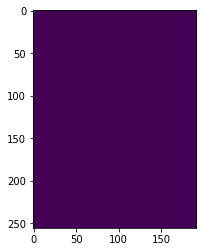

In [84]:
img, hp, confidence = mycoco[id_to_path[185302]]  #1124
# print(mycoco.target_kp)
print(hp.shape)
print(img.shape)
plt.imshow(np.stack(hp).max(axis=0))

In [91]:
training_data = CustomCOCO(train_coco_json_path, train_coco_img_path)
#test_data = CustomCOCO(test_coco_json_path, test_coco_img_path)

In [92]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)
#test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
for i, (image, label, visibility) in enumerate(train_dataloader):
    #print("i: ",i)
    #plt.imshow(image)
    if i%10 == 0:
        print("i: ", i)